This notebook contains a collection of different ways Python can be used in the context of GIS.

See this GitHub repository by Christopher Roach for an excellent tutorial on the use of Python for mapping:
<br>
https://github.com/croach/oreilly-matplotlib-course/tree/master/07%20-%20Mapping%20in%20matplotlib

Date Created: 11 Feb 2018
<br>
Last Modified: 27 Feb 2018 
<br>
Humans Responsible: The Prickly Pythons

In [2]:
%matplotlib inline

## 1. Matplotlib's Basemap Toolkit
Documentation: https://matplotlib.org/basemap/
<br>
Installation via Anaconda:
`conda install basemap`
<br>
Basemap will eventually be replaced by [Cartopy](http://scitools.org.uk/cartopy/). See this [link](https://matplotlib.org/basemap/users/intro.html#cartopy-new-management-and-eol-announcement) for more information.

In [1]:
import numpy as np
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, Polygon

## Map projections
Going from 3D to 2D.

Adapted from: 
<br>
https://github.com/croach/oreilly-matplotlib-course/blob/master/07%20-%20Mapping%20in%20matplotlib/0701%20-%20What%20is%20a%20Map%20Projection%3F.ipynb

### The Mercator Projection - preseves angles

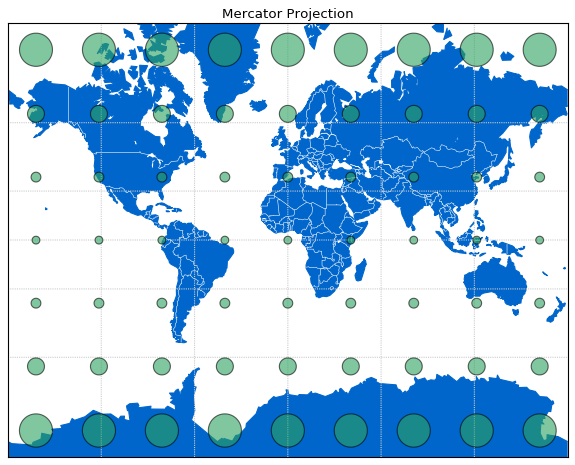

In [86]:
plt.figure(figsize=(14,7))

# Create a Basemap instance that uses the mercator projection
m = Basemap(projection='merc',
            urcrnrlat=80, llcrnrlat=-80,      # Top and Bottom parallels
            llcrnrlon=-180, urcrnrlon=180)    # Left and Right meridians

# Draw the coastlines and fill the continents all with the same blue.
# The color of inland lakes defaults to the background color of the 
# axis, but we'll set the lake_color here to make sure that it is white.
m.drawcoastlines(color='#0066CC')
m.fillcontinents(color='#0066CC', lake_color='white')

# Draw the boundaries of each country in white
m.drawcountries(color='white')

# Draw lines of latitude (parallels) and longitude (meridians)
m.drawparallels(range(-90,91,30), color='#CCCCCC')
m.drawmeridians(range(-180,181,60), color='#CCCCCC')

# Draws the bounding box around the map and sets the background 
# color (fill_color) for the entire map. 
m.drawmapboundary(fill_color='white')

# Give the map a title
plt.title("Mercator Projection")

# Draw Tissot's indicatrix to show distortion.
for y in np.linspace(m.xmax/20, 19*m.xmax/20, 9):
    for x in np.linspace(m.xmax/20, 19*m.xmax/20, 9):
        lon, lat = m(x,y,inverse=True)
        poly = m.tissot(lon, lat, 2.5, 100, facecolor='#2ca25f', zorder=10, alpha=0.6);

### The Mollweide Projection - preseves area

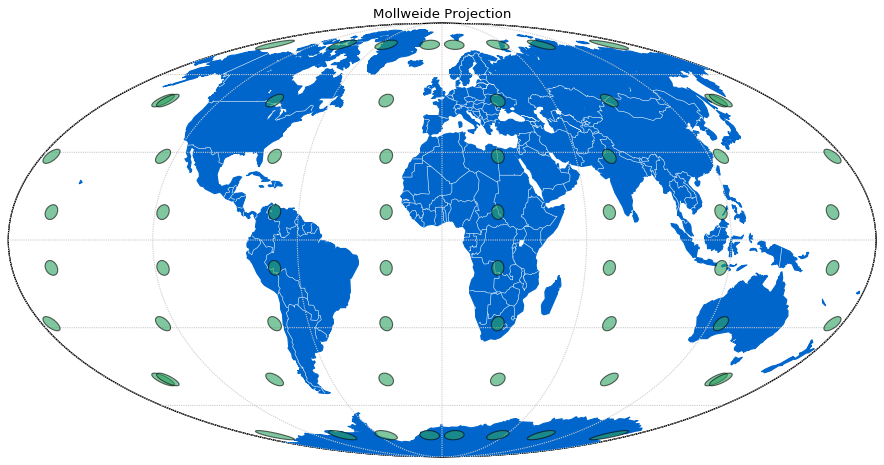

In [96]:
plt.figure(figsize=(14,7))

# Create a Basemap instance that uses the mercator projection
m = Basemap(projection='moll',
            lon_0=0)

# Draw the coastlines and fill the continents all with the same blue.
# The color of inland lakes defaults to the background color of the 
# axis, but we'll set the lake_color here to make sure that it is white.
m.drawcoastlines(color='#0066CC')
m.fillcontinents(color='#0066CC', lake_color='white')

# Draw the boundaries of each country in white
m.drawcountries(color='white')

# Draw lines of latitude (parallels) and longitude (meridians)
m.drawparallels(range(-90,91,30), color='#CCCCCC')
m.drawmeridians(range(-180,181,60), color='#CCCCCC')

# Draws the bounding box around the map and sets the background 
# color (fill_color) for the entire map. 
m.drawmapboundary(fill_color='white')

# Give the map a title
plt.title("Mollweide Projection")

# Draw Tissot's indicatrix to show distortion.
for y in np.linspace(m.ymax/20, 19*m.ymax/20, 8):
    for x in np.linspace(m.xmax/20, 19*m.xmax/20, 8):
        lon, lat = m(x,y,inverse=True)
        poly = m.tissot(lon, lat, 2.5, 100, facecolor='#2ca25f', zorder=10, alpha=0.6);

In [5]:
m

In [24]:
from mpl_toolkits import basemap
print(basemap.supported_projections)

 vandg            van der Grinten                         
 nsper            Near-Sided Perspective                  
 kav7             Kavrayskiy VII                          
 poly             Polyconic                               
 mill             Miller Cylindrical                      
 tmerc            Transverse Mercator                     
 cass             Cassini-Soldner                         
 eqdc             Equidistant Conic                       
 gnom             Gnomonic                                
 aea              Albers Equal Area                       
 robin            Robinson                                
 npaeqd           North-Polar Azimuthal Equidistant       
 npstere          North-Polar Stereographic               
 lcc              Lambert Conformal                       
 eck4             Eckert IV                               
 nplaea           North-Polar Lambert Azimuthal           
 geos             Geostationary                         

## 2. Making a choropleth with Basemap and Pandas
Adapted from: http://ramiro.org/notebook/basemap-choropleth/

Ingridients:
- [Geonamescache](https://pypi.python.org/pypi/geonamescache) package. Command: `pip install geonamescache`
- Country borders from [Natural Earth Data](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/)
- Data from [World Bank Open Data](https://data.worldbank.org/indicator/AG.LND.FRST.K2?view=map&year=2015)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

In [2]:
# Setup
filename = 'data/forest_area/API_AG.LND.FRST.ZS_DS2_en_csv_v2.csv'
shapefile = 'data/ne_10m_admin_0_countries/ne_10m_admin_0_countries'
num_colors = 21
year = '2015'
cols = ['Country Name', 'Country Code', year]
title = 'Forest area as percentage of land area in %s' % year
description = '''
Forest area is land under natural or planted stands of trees of at least 5 meters in situ, whether productive or not, and excludes tree stands in agricultural production systems (for example, in fruit plantations
and agroforestry systems) and trees in urban parks and gardens. Countries without data are shown in grey. Data: World Bank - worldbank.org'''.strip()

In [3]:
# Get iso3 country codes 
gc = GeonamesCache()
iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

In [4]:
# Read in data using Pandas
df = pd.read_csv(filename, skiprows=4, usecols=cols)
df.head(10)

,Country Name,Country Code,2015
0,Aruba,ABW,2.333333
1,Afghanistan,AFG,2.067825
2,Angola,AGO,46.407315
3,Albania,ALB,28.156934
4,Andorra,AND,34.042553
5,Arab World,ARB,2.802680
6,United Arab Emirates,ARE,3.858852
7,Argentina,ARG,9.906858
8,Armenia,ARM,11.661398
9,American Samoa,ASM,87.700000


In [5]:
# Use the country codes as index
df.set_index('Country Code', inplace=True)
df = df.ix[iso3_codes].dropna() # Filter out non-countries and missing values.
df.head(10)

,Country Name,2015
Country Code,,
UZB,Uzbekistan,7.569111
POL,Poland,30.814200
NER,Niger,0.901555
BEN,Benin,38.231642
CHE,Switzerland,31.733981
ZWE,Zimbabwe,36.350006
LBN,Lebanon,13.421310
IRQ,Iraq,1.899521
NOR,Norway,33.161303


In [6]:
# Assign colour values to the data
values = df[year]
cm = plt.get_cmap('Greens')
scheme = [cm(i / num_colors) for i in range(num_colors)]

bins = np.linspace(0, 100, num_colors)
df['bin'] = np.digitize(values, bins) - 1
df.sort_values('bin', ascending=False).tail(10)

,Country Name,2015,bin
Country Code,,,
MLT,Malta,1.093750,0
FRO,Faroe Islands,0.057307,0
TCD,Chad,3.871506,0
YEM,"Yemen, Rep.",1.039832,0
TJK,Tajikistan,2.968599,0
BHR,Bahrain,0.778210,0
SMR,San Marino,0.000000,0
JOR,Jordan,1.098220,0
DZA,Algeria,0.821248,0


In [7]:
bins

array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.])

### Start making a map!

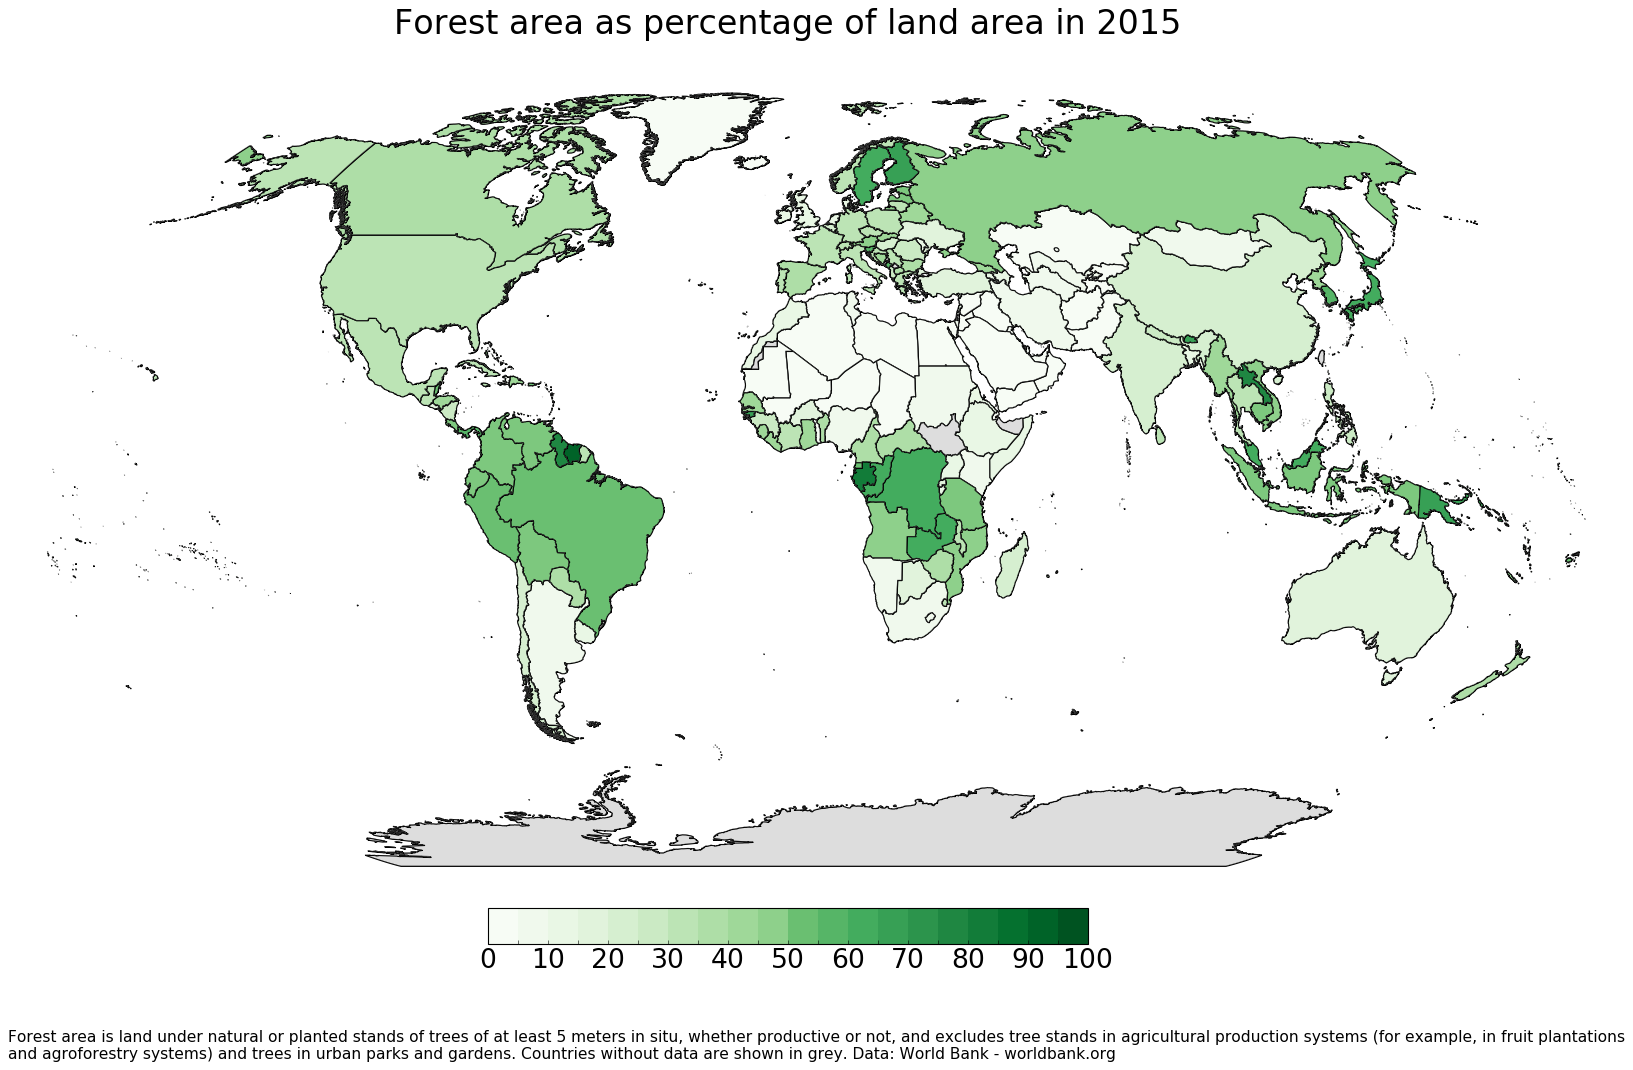

In [27]:
# Step 1: Plot the map
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# Draw map
m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')
m.readshapefile(shapefile, 'units', color='#444444', linewidth=0.2)


# Step 2: Colour the map
for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in df.index:
        color = '#dddddd' #Grey
    else:
        color = scheme[df.ix[iso3]['bin']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

    
# Step 3: Add title, colorbar and annotation
fig.suptitle(title, fontsize=30, y=0.9)

# Draw color legend
ax_legend = fig.add_axes([0.35, 0.12, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')

# For making nice tick labels
x_tick_labels_list = [str(int(i)) for i in bins]
for ii in range(0,bins.size):
    if np.mod(ii,2):
        x_tick_labels_list[ii] = ''
cb.ax.set_xticklabels(x_tick_labels_list)

plt.xticks(fontsize=24)

# Set the map footer
plt.annotate(description, xy=(-0.8, -3.2), size=14, xycoords='axes fraction')

plt.show()